In [1]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 1.8/72.0 MB 20.2 MB/s eta 0:00:04
   --- ------------------------------------ 5.8/72.0 MB 18.5 MB/s eta 0:00:04
   ------ --------------------------------- 11.0/72.0 MB 21.5 MB/s eta 0:00:03
   ------- -------------------------------- 13.4/72.0 MB 21.0 MB/s eta 0:00:03
   ---------- ----------------------------- 19.1/72.0 MB 23.7 MB/s eta 0:00:03
   -------------- ------------------------- 26.7/72.0 MB 22.9 MB/s eta 0:00:02
   ----------------- ---------------------- 31.5/72.0 MB 22.7 MB/s eta 0:00:02
   -------------------- ------------------- 36.4/72.0 MB 22.7 MB/s eta 0:00:02
   -------------------- ------------------- 37.5/72.0 MB 22.1 MB/s eta 0:00:02
   ----------------------- ---------------- 43.0/72.0 MB 21.2 MB/s eta 0:00:02
   -------------------------- ------------- 46.9/72.0 MB 21.5 MB/s eta 0:00:02
   --------------------------- ------------ 49.8/72.0 MB 20.6 M

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, auc, 
                             roc_auc_score, classification_report)
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

In [3]:
# Загрузка датасета
df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome'] # целевая переменная: диабет присутствует или отсутствует
features = X.columns.tolist()

print(f'Размер датасета: {df.shape[0]} x {df.shape[1]}')
print(df.head())

Размер датасета: 768 x 9
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')

Train: (614, 8)
Test: (154, 8)


- - - - - - - -
**Задание №1:**

Решить задачу классификации  больных методом **случайного леса**.

-	Провевести исследование качества модели от глубины используемых деревьев. Отрисовать зависимость на графике.
-	Провести исследование качества модели от количества подаваемых на дерево признаков. Отрисовать зависимость на графике.
-	Провести исследование качества модели от числа деревьев. Отрисовать на графике, дополнить график данными о времени обучения.


In [5]:
def evaluation(model, X_train, X_test, y_train, y_test, model_name="Модель"):
    
    start_time = time.time()
    model.fit(X_train, y_train) # обучение
    train_time = time.time() - start_time
    y_train_predict = model.predict(X_train)
    y_test_predict = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_test_proba)
    else:
        y_test_proba = None
        roc_auc = None
    metrics = {
        'Модель': model_name,
        'Время обучения (с)': train_time,
        'Accuracy (train)': accuracy_score(y_train, y_train_predict),
        'Accuracy (test)': accuracy_score(y_test, y_test_predict),
        'Precision': precision_score(y_test, y_test_predict),
        'Recall': recall_score(y_test, y_test_predict),
        'F1-Score': f1_score(y_test, y_test_predict),
        'ROC-AUC': roc_auc
    }
    
    return metrics, y_test_proba

In [ ]:
# Влияние глубины деревьев на качество случайного леса
max_depths = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, None]
depth_results = []
depth_times = []

for depth in max_depths:
    depth_label = depth if depth is not None else "Без ограничений"
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=depth,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    start_time = time.time()
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_time = time.time() - start_time

    rf.fit(X_train, y_train) # обучение
    y_test_proba = rf.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    depth_results.append({
        'max_depth': depth_label,
        'CV ROC-AUC mean': cv_scores.mean(),
        'CV ROC-AUC std': cv_scores.std(),
        'Test ROC-AUC': test_roc_auc,
        'Время CV (с)': cv_time
    })
    
    print(f'Глубина {depth_label}: ROC - AUC = {cv_scores.mean():.4f} +- {cv_scores.std():.4f}')

depth_df = pd.DataFrame(depth_results)

Глубина 1: ROC - AUC = 0.8225 +- 0.0209
Глубина 2: ROC - AUC = 0.8279 +- 0.0212
Глубина 3: ROC - AUC = 0.8286 +- 0.0217
Глубина 5: ROC - AUC = 0.8360 +- 0.0170
Глубина 7: ROC - AUC = 0.8296 +- 0.0154
Глубина 10: ROC - AUC = 0.8208 +- 0.0181
Глубина 15: ROC - AUC = 0.8198 +- 0.0161
Глубина 20: ROC - AUC = 0.8195 +- 0.0174
Глубина 25: ROC - AUC = 0.8196 +- 0.0178
Глубина 30: ROC - AUC = 0.8196 +- 0.0178
Глубина Без ограничений: ROC - AUC = 0.8196 +- 0.0178


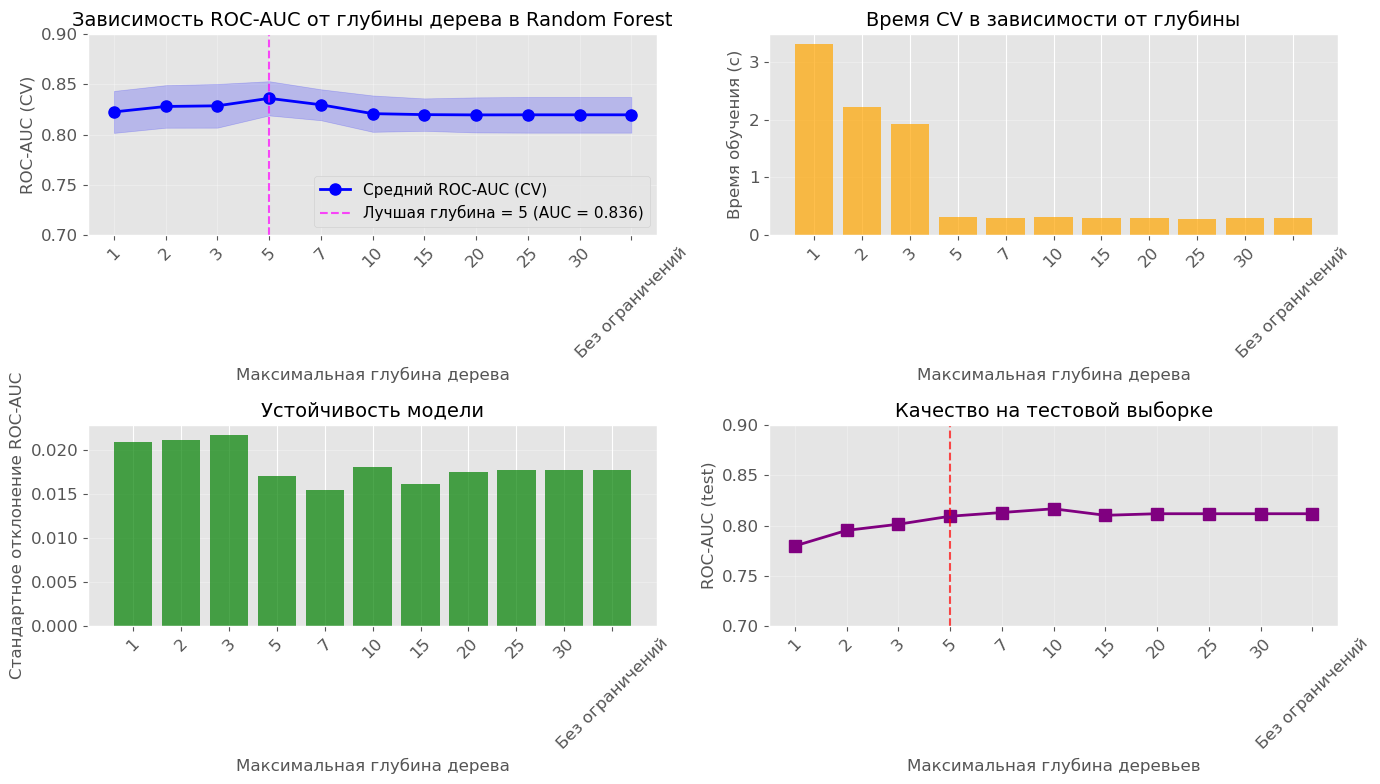

In [ ]:
# График зависимости ROC-AUC от глубины деревьев
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
x_labels = [str(d) for d in depth_df['max_depth']]
x_pos = np.arange(len(x_labels))
plt.plot(x_pos, depth_df['CV ROC-AUC mean'], 'o-', linewidth=2, markersize=8, label='Средний ROC-AUC (CV)', color='blue')
plt.fill_between(x_pos, 
                 depth_df['CV ROC-AUC mean'] - depth_df['CV ROC-AUC std'],
                 depth_df['CV ROC-AUC mean'] + depth_df['CV ROC-AUC std'],
                 alpha=0.2, color='blue')

# Лучшая глубина
best_depth_idx = depth_df['CV ROC-AUC mean'].idxmax()
best_depth = depth_df.loc[best_depth_idx, 'max_depth']
best_auc = depth_df.loc[best_depth_idx, 'CV ROC-AUC mean']
plt.axvline(x=best_depth_idx, color='magenta', linestyle='--', alpha=0.7, label=f'Лучшая глубина = {best_depth} (AUC = {best_auc:.3f})')

plt.xticks(x_pos, x_labels, rotation=45)
plt.xlabel('Максимальная глубина деревьев', fontsize=12)
plt.ylabel('ROC-AUC (CV)', fontsize=12)
plt.title('Зависимость ROC-AUC от глубины деревьев в Random Forest', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0.7, 0.9)

plt.subplot(2, 2, 2)
plt.bar(x_pos, depth_df['Время CV (с)'], color='orange', alpha=0.7)
plt.xticks(x_pos, x_labels, rotation=45)
plt.xlabel('Максимальная глубина деревьев', fontsize=12)
plt.ylabel('Время обучения (c)', fontsize=12)
plt.title('Время CV в зависимости от глубины', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 2, 3)
plt.bar(x_pos, depth_df['CV ROC-AUC std'], color='green', alpha=0.7)
plt.xticks(x_pos, x_labels, rotation=45)
plt.xlabel('Максимальная глубина деревьев', fontsize=12)
plt.ylabel('Стандартное отклонение ROC-AUC', fontsize=12)
plt.title('Устойчивость модели', fontsize=14) # чем меньше, тем лучше
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 2, 4)
plt.plot(x_pos, depth_df['Test ROC-AUC'], 's-', linewidth=2, markersize=8,
         label='ROC-AUC на тесте', color='purple')
plt.axvline(x=best_depth_idx, color='red', linestyle='--', alpha=0.7)
plt.xticks(x_pos, x_labels, rotation=45)
plt.xlabel('Максимальная глубина деревьев', fontsize=12)
plt.ylabel('ROC-AUC (test)', fontsize=12)
plt.title('Качество на тестовой выборке', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0.7, 0.9)

plt.tight_layout()
plt.show()

In [13]:
# Влияние количества признаков на качество случайного леса
max_features_options = ['sqrt', 'log2', 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, None]
max_features_labels = ['sqrt', 'log2', '10%', '20%', '30%', '50%', '70%', '90%', 'all']
features_results = []
for i, max_feat in enumerate(max_features_options):
    feat_label = max_features_labels[i]
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=best_depth if best_depth != "Без ограничений" else None,
        max_features=max_feat,
        random_state=42,
        n_jobs=-1
    )

    start_time = time.time()
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_time = time.time() - start_time
    
    rf.fit(X_train, y_train) # обучение
    y_test_proba = rf.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    features_results.append({
        'max_features': feat_label,
        'CV ROC-AUC mean': cv_scores.mean(),
        'CV ROC-AUC std': cv_scores.std(),
        'ROC-AUC (test)': test_roc_auc,
        'Время CV (с)': cv_time
    })
    
    print(f"Кол-во признаков {feat_label:>4}: ROC - AUC = {cv_scores.mean():.4f} +- {cv_scores.std():.4f}")

features_df = pd.DataFrame(features_results)

Кол-во признаков sqrt: ROC - AUC = 0.8360 +- 0.0170
Кол-во признаков log2: ROC - AUC = 0.8340 +- 0.0203
Кол-во признаков  10%: ROC - AUC = 0.8267 +- 0.0176
Кол-во признаков  20%: ROC - AUC = 0.8267 +- 0.0176
Кол-во признаков  30%: ROC - AUC = 0.8360 +- 0.0170
Кол-во признаков  50%: ROC - AUC = 0.8367 +- 0.0215
Кол-во признаков  70%: ROC - AUC = 0.8327 +- 0.0206
Кол-во признаков  90%: ROC - AUC = 0.8362 +- 0.0203
Кол-во признаков  all: ROC - AUC = 0.8302 +- 0.0225


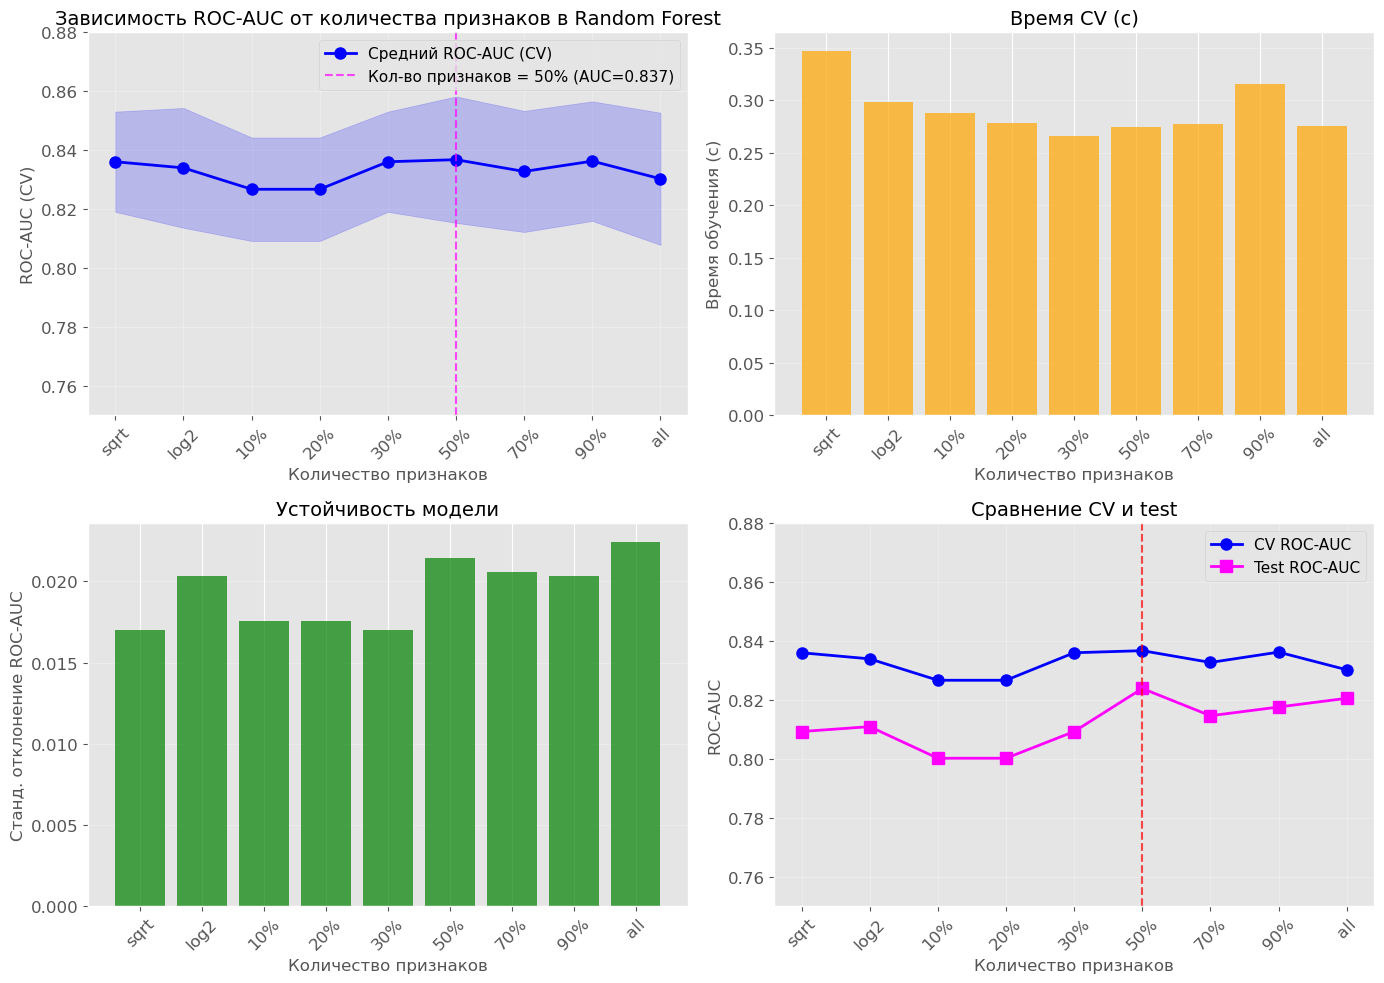

In [12]:
# График зависимости ROC-AUC от количества признаков
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
x_pos = np.arange(len(features_df['max_features']))

plt.plot(x_pos, features_df['CV ROC-AUC mean'], 'o-', linewidth=2, markersize=8, label='Средний ROC-AUC (CV)', color='blue')
plt.fill_between(x_pos, 
                 features_df['CV ROC-AUC mean'] - features_df['CV ROC-AUC std'],
                 features_df['CV ROC-AUC mean'] + features_df['CV ROC-AUC std'],
                 alpha=0.2, color='blue')

best_feat_idx = features_df['CV ROC-AUC mean'].idxmax()
best_feat = features_df.loc[best_feat_idx, 'max_features']
best_auc = features_df.loc[best_feat_idx, 'CV ROC-AUC mean']
plt.axvline(x=best_feat_idx, color='magenta', linestyle='--', alpha=0.7, label=f'Кол-во признаков = {best_feat} (AUC={best_auc:.3f})')

plt.xticks(x_pos, features_df['max_features'], rotation=45)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('ROC-AUC (CV)', fontsize=12)
plt.title('Зависимость ROC-AUC от количества признаков в Random Forest', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0.75, 0.88)

plt.subplot(2, 2, 2)
plt.bar(x_pos, features_df['Время CV (с)'], color='orange', alpha=0.7)
plt.xticks(x_pos, features_df['max_features'], rotation=45)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('Время обучения (c)', fontsize=12)
plt.title('Время CV (c)', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 2, 3)
plt.bar(x_pos, features_df['CV ROC-AUC std'], color='green', alpha=0.7)
plt.xticks(x_pos, features_df['max_features'], rotation=45)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('Станд. отклонение ROC-AUC', fontsize=12)
plt.title('Устойчивость модели', fontsize=14) # чем меньше, тем лучше
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 2, 4)
plt.plot(x_pos, features_df['CV ROC-AUC mean'], 'o-', linewidth=2, markersize=8, label='CV ROC-AUC', color='blue')
plt.plot(x_pos, features_df['ROC-AUC (test)'], 's-', linewidth=2, markersize=8, label='Test ROC-AUC', color='magenta')
plt.axvline(x=best_feat_idx, color='red', linestyle='--', alpha=0.7)
plt.xticks(x_pos, features_df['max_features'], rotation=45)
plt.xlabel('Количество признаков', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title('Сравнение CV и test', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0.75, 0.88)

plt.tight_layout()
plt.show()

In [16]:
# Влияние количества деревьев на качество случайного леса
n_estimators_options = [1, 5, 10, 20, 30, 50, 75, 100, 150, 200, 300, 500]
n_trees_results = []
for n_trees in n_estimators_options:
    rf = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=best_depth if best_depth != "Без ограничений" else None,
        max_features=best_feat if best_feat not in ['sqrt', 'log2', 'all'] 
        else (best_feat if best_feat == 'sqrt' else 
              'log2' if best_feat == 'log2' else None),
        random_state=42,
        n_jobs=-1
    )

    start_time = time.time()
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    train_time = time.time() - start_time

    rf.fit(X_train, y_train) # обучение
    y_test_proba = rf.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_test_proba)

    if n_trees == n_estimators_options[-1]:
        feature_importances = rf.feature_importances_ # важность признаков для полной модели

    n_trees_results.append({
        'n_estimators': n_trees,
        'CV ROC-AUC mean': cv_scores.mean(),
        'CV ROC-AUC std': cv_scores.std(),
        'ROC-AUC (test)': test_roc_auc,
        'Время обучения (с)': train_time
    })
    
    print(f"Кол-во деревьев {n_trees:>3}: ROC - AUC = {cv_scores.mean():.4f}, время = {train_time:.2f}с")

trees_df = pd.DataFrame(n_trees_results)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\conda\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\conda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\conda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got '50%' instead.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "d:\conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\conda\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\conda\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\conda\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got '50%' instead.


In [ ]:
# График зависимости ROC-AUC от количества деревьев

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].plot(trees_df['n_estimators'], trees_df['CV ROC-AUC mean'], 'o-', linewidth=2, markersize=8, color='blue', label='CV ROC-AUC')
axes[0, 0].fill_between(trees_df['n_estimators'],
                        trees_df['CV ROC-AUC mean'] - trees_df['CV ROC-AUC std'],
                        trees_df['CV ROC-AUC mean'] + trees_df['CV ROC-AUC std'],
                        alpha=0.2, color='blue')

# Поиск точки, после которой улучшения незначительные
for i in range(1, len(trees_df)):
    improvement = trees_df.loc[i, 'CV ROC-AUC mean'] - trees_df.loc[i-1, 'CV ROC-AUC mean']
    if improvement < 0.001 and i > 5:
        best_trees = trees_df.loc[i-1, 'n_estimators']
        best_trees_auc = trees_df.loc[i-1, 'CV ROC-AUC mean']
        axes[0, 0].axvline(x=best_trees, color='magenta', linestyle='--', alpha=0.7,
                          label=f'Лучшее кол-во деревьев = {best_trees}')
        break

axes[0, 0].set_xlabel('Количество деревьев (n_estimators)', fontsize=12)
axes[0, 0].set_ylabel('ROC-AUC (кросс-валидация)', fontsize=12)
axes[0, 0].set_title('Зависимость ROC-AUC от количества деревьев', fontsize=14)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(trees_df['n_estimators'], trees_df['Время обучения (с)'], 's-', linewidth=2, markersize=8, color='orange')
axes[0, 1].set_xlabel('Кол-во деревьев (n_estimators)', fontsize=12)
axes[0, 1].set_ylabel('Время обучения (c)', fontsize=12)
axes[0, 1].set_title('Время обучения в зависимости от количества деревьев', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(trees_df['n_estimators'], trees_df['Test ROC-AUC'], '^-', linewidth=2, markersize=8, color='red')
if 'best_trees' in locals():
    best_test_auc = trees_df[trees_df['n_estimators'] == best_trees]['Test ROC-AUC'].values[0]
    axes[1, 0].axvline(x=best_trees, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_xlabel('Количество деревьев (n_estimators)', fontsize=12)
axes[1, 0].set_ylabel('ROC-AUC (test)', fontsize=12)
axes[1, 0].set_title('Качество на test', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(trees_df['n_estimators'][1:], 
                np.diff(trees_df['CV ROC-AUC mean']) / trees_df['CV ROC-AUC mean'].values[:-1] * 100,
                'd-', linewidth=2, markersize=8, color='green')
axes[1, 1].axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Порог 0.001')
axes[1, 1].set_xlabel('Количество деревьев (n_estimators)', fontsize=12)
axes[1, 1].set_ylabel('Относительное улучшение (%)', fontsize=12)
axes[1, 1].set_title('Относительное улучшение ROC-AUC', fontsize=14)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- - - - - - - - -
**Задание №2:**

Решить задачу классификации с использованием XGBoost. 

Исследовать время обучения, качество полученных результатов. Сравнить с данными полученными в п.1 и сделать выводы (в работе). 

Гиперпараметры модели подбираются в этой лабораторной вручную. Цель – попытаться найти лучшие значения и почувствовать рабочие диапазоны параметров.

In [ ]:
# доделать!!!